This is a simple Heron model trained off a surrogate model.

In [1]:
import heron
from heron import waveform
from george import kernels
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use("/home/daniel/papers/thesis/thesis-style.mpl")
import astropy.constants as c

In [3]:
import thesis

In [4]:
import elk
import elk.catalogue

In [5]:
import matplotlib.gridspec as gridspec
def sample_plot(p, surrogates=None):
    """
    Make a plot to compare sample draws from the GPR to SEOBNRv4 and 
    IMRPhenomPv2.
    """
    f = plt.figure(constrained_layout=True, dpi=300)#, dpi=500)
    gs = gridspec.GridSpec(1,4, figure = f)
    
    samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-250, 200, 1024], samples=100)

    time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value) #*1e4
    h_factor = c.pc.value
    
    
        # Waveform plot
    times = samples[0].times/1e4 #np.linspace(-150, 100, 1024)/1e4
    #std = np.array(waveforms).std(axis=0)
    ax_wave = f.add_subplot(gs[0:4])
    #ax_hist = f.add_subplot(gs[3])
    

    for sample in samples[1:]:
        ax_wave.plot(sample.times*time_factor, sample.data*h_factor, color='k', alpha=0.0525, lw=0.5)
        
    ax_wave.plot(samples[0].times*time_factor, samples[0].data*h_factor, color='k', alpha=0.0525, lw=0.5, label="GPR Draws")
    mean, variance = gp_cat.waveform(p=p, time_range=[-250.,200.,1024])
    ax_wave.plot(mean.times*time_factor, mean.data*h_factor, label = "GPR Mean", 
                 linestyle="--",
                 alpha=0.5, color='k', lw=2)
    ax_wave.fill_between(mean.times*time_factor, (mean.data+(variance.data))*h_factor, (mean.data-(variance.data))*h_factor, alpha=0.1, color='k', label="GPR Variance")

    
    ax_wave.set_xlabel(r"$(t - t_{\rm peak})/M$", fontdict=thesis.lato)
    ax_wave.set_ylabel(r"$r h_{2,2}$", fontdict=thesis.lato)

    if surrogates:
        if not type(surrogates)==list:
            surrogates = [surrogates]
        for surrogate in surrogates:
            p['mass ratio'] = np.exp(p['mass ratio'])
            wave = surrogate.waveform(time_range=[-250.,200.,1024], p=p, )
            ax_wave.plot((wave[0].times)*time_factor, wave[0].data*h_factor, alpha=0.7)

    
    f = thesis.thesisify(f)
    
    return f#, ax

In [6]:
def plot_planes(ranges, fixed):
    """
    Produce a plot of the waveform predictions from
    the GP.

    Parameters
    ----------
    ranges : dict
       A dictionary in which the keys are the name of the parameter
       and the values are a list in the format [start, end, npoints]
       at which the GP should be evaluated for the plane.
    fixed : dict
       A dictionary in which the keys are the name of the parameter
       which should be fixed, and the value is the fixed value of 
       that parameter.
    """

    mean, var = gp_cat.mean(ranges, fixed)

    ranges_x = list(ranges.items())[0][1]
    ranges_y = list(ranges.items())[1][1]
    total_mass = 60
    time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value)/1e4
    #f, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    
    f = plt.figure(dpi=300)
    
    gs = gridspec.GridSpec(4,4, figure = f)
    ax = f.add_subplot(gs[0:4, 0:2])
    
    im = ax.imshow(mean, origin="lower", cmap = "magma",
                   alpha=0.8,
                   extent = (np.exp(ranges_x[0]), np.exp(ranges_x[1]), ranges_y[0]*time_factor, ranges_y[1]*time_factor),
                   aspect = ( (np.exp(ranges_x[1]) - np.exp(ranges_x[0]))
                              / (ranges_y[1]*time_factor - ranges_y[0]*time_factor )))
    #cax = f.add_axes([0.9, 0.1, 0.02, 0.8])
    #f.colorbar(im, cax=cax, orientation='vertical')

    #g, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    ax2 = f.add_subplot(gs[0:4, 2:4], sharey=ax)
    im = ax2.imshow(np.abs(var), origin="lower",
                   cmap = "viridis",
                   extent = (np.exp(ranges_x[0]), np.exp(ranges_x[1]), ranges_y[0]*time_factor, ranges_y[1]*time_factor),
                   aspect = ( (np.exp(ranges_x[1]) - np.exp(ranges_x[0]))
                              / ((ranges_y[1] - ranges_y[0] )*time_factor)))
    #ax3 = f.add_subplot(gs[3, 2:4])
    #ax3.plot(np.linspace(ranges_x[0], ranges_x[1], ranges_x[2]), var.sum(axis=0))
    #cax = g.add_axes([0.9, 0.1, 0.02, 0.8])
    #cax.yaxis.get_offset_text().set_fontproperties(ticks_font)
    #g.colorbar(im, cax=cax, orientation='vertical')

    ax.set_xscale('log')
    ax2.set_xscale('log')
    from matplotlib.ticker import FormatStrFormatter

    ax.set_xlabel("Mass ratio")
    ax2.set_xlabel("Mass ratio")
    ax.xaxis.set_minor_formatter(FormatStrFormatter(''))
    ax2.xaxis.set_minor_formatter(FormatStrFormatter(''))
    ax.set_ylabel("Time [ms]", fontdict=thesis.lato)
    plt.setp(ax2.get_yticklabels(), visible=False)
    #ax3.set_xlabel(list(ranges.keys())[0],  fontdict=thesis.lato)
    f.axes[0].grid(alpha=0.3)
    f.axes[1].grid(alpha=0.3)
    f = thesis.thesisify(f)
    return f, mean, var

In [7]:
waveforms = [{"mass ratio": m, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0}
                                               for m in np.logspace(-1.0, 0 , 15)]
#waveforms.append({"mass ratio": 0.17, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
#waveforms.append({"mass ratio": 0.77, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
#waveforms.append({"mass ratio": 0.47, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})

In [8]:
total_mass = 60
imr_cat = elk.catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    fmin=95,
                                    waveforms=waveforms
                                   )

In [9]:
training = imr_cat.create_training_data(total_mass=60, sample_rate=4096)

/home/daniel/.virtualenvs/IGRlaptop21/heron-stable/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


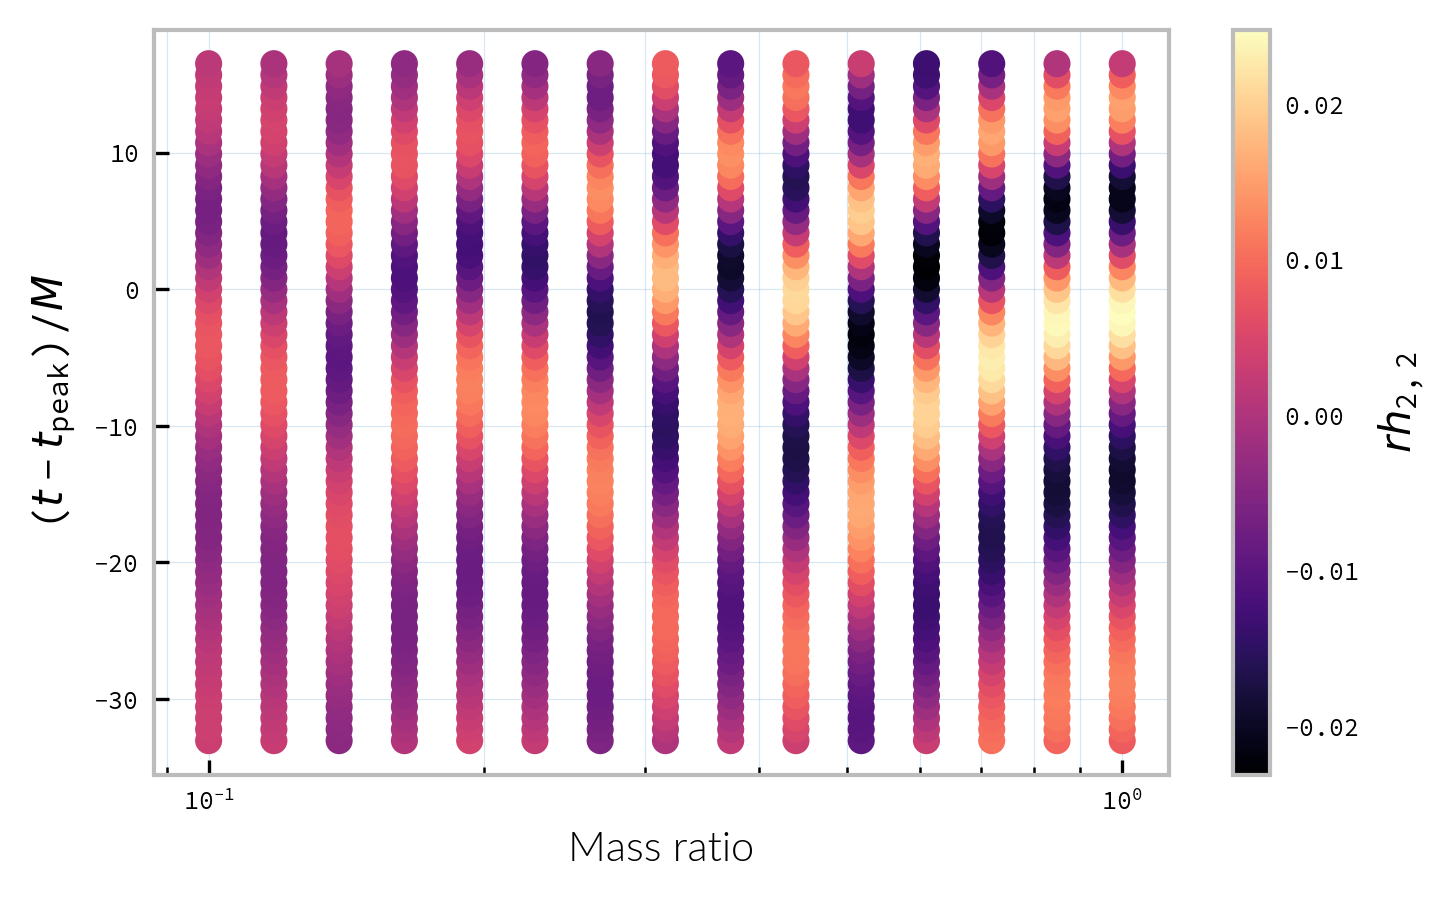

In [10]:
total_mass=60
h_factor = c.pc.value
time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value) #*1e4
f, ax = plt.subplots(1,1, dpi=300)
po = ax.scatter(training[:,1], training[:,0]*time_factor,  c=h_factor*training[:,-1], cmap='magma')
ax.set_xscale("log")
ax.set_xlabel("Mass ratio")
ax.set_ylabel(r"$(t - t_{\rm peak})/M$")
cax = plt.colorbar(po)
#ax.set_ylim([-40,20])
cax.set_label(r"$r h_{2,2}$")
f = thesis.thesisify(f)
f.savefig("../../figures/heron/imr-test-training.pdf")

In [11]:
problem_dims = 2 # This model only has mass ratio and time in it
c_ind = imr_cat.c_ind
time_covariance = kernels.ExpSquaredKernel(195,
                                           ndim=problem_dims,
                                           axes=c_ind['time'],)
mass_covariance = kernels.ExpSquaredKernel(0.005, 
                                           ndim=problem_dims,
                                           axes=c_ind['mass ratio'])
covariance =  8 * mass_covariance * time_covariance 

gp = gp_cat = waveform.GPCatalogue(imr_cat, covariance,
                                   total_mass=total_mass, fsample=4096,
                                   mean=0.0,
                                   ma=[(2,2)],
                                   solver="hodlr",
                                   tmax=0.02,
                                   tmin=-0.025,
                                   white_noise=1e-6,)

Computing


In [152]:
gp_cat.optimise('bfgs', max_iter=2000)

Location: [4.28241860e+00 1.94092671e-03 1.72782232e+02]
log(evidence): -3624.53902325
Location: [4.27574694e+00 1.67535496e-03 1.80552777e+02]
log(evidence): -3608.07220245
Location: [3.76390159e+00 1.07649369e-03 1.96259939e+02]
log(evidence): -3569.87231894
Location: [3.03360343e+00 4.40865900e-04 2.06669700e+02]
log(evidence): -3533.44259846
Location: [2.96679945e+00 4.33517332e-04 1.84807230e+02]
log(evidence): -3526.08494774
Location: [2.88125748e+00 4.10247501e-04 1.76103054e+02]
log(evidence): -3525.22788565
Location: [2.87671351e+00 4.09379057e-04 1.75890247e+02]
log(evidence): -3525.20908187
Location: [2.76726896e+00 3.93847637e-04 1.72069173e+02]
log(evidence): -3524.50908786
Location: [2.76726896e+00 3.93847637e-04 1.72069173e+02]
log(evidence): -3524.50908702


/home/daniel/.virtualenvs/IGRlaptop21/heron-stable/local/lib/python2.7/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


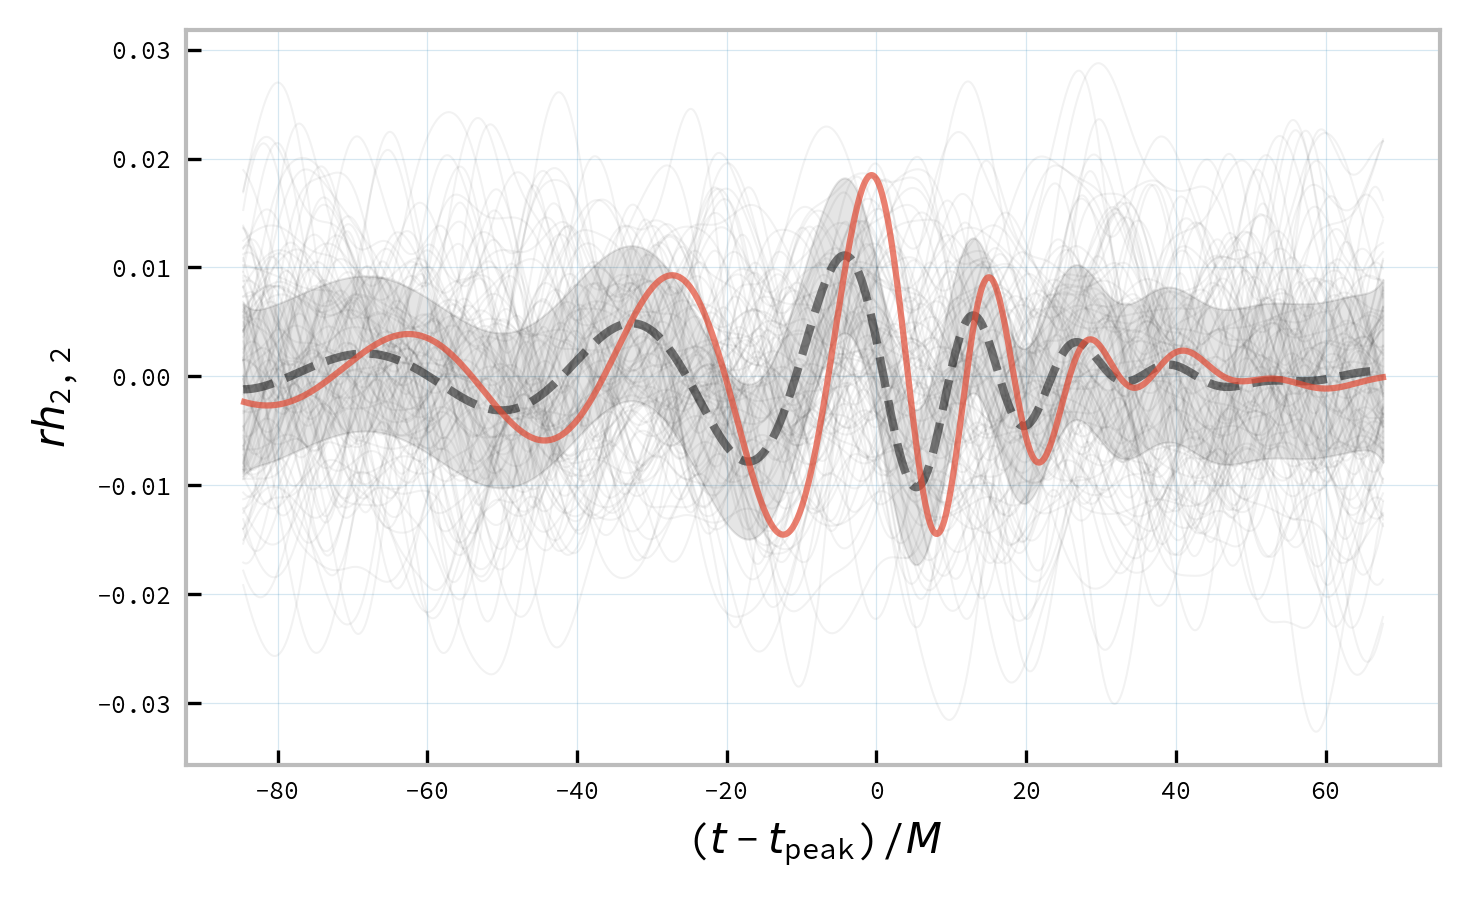

In [12]:
p = {"mass ratio": 0.33,}
f = sample_plot(p, surrogates=imr_cat)

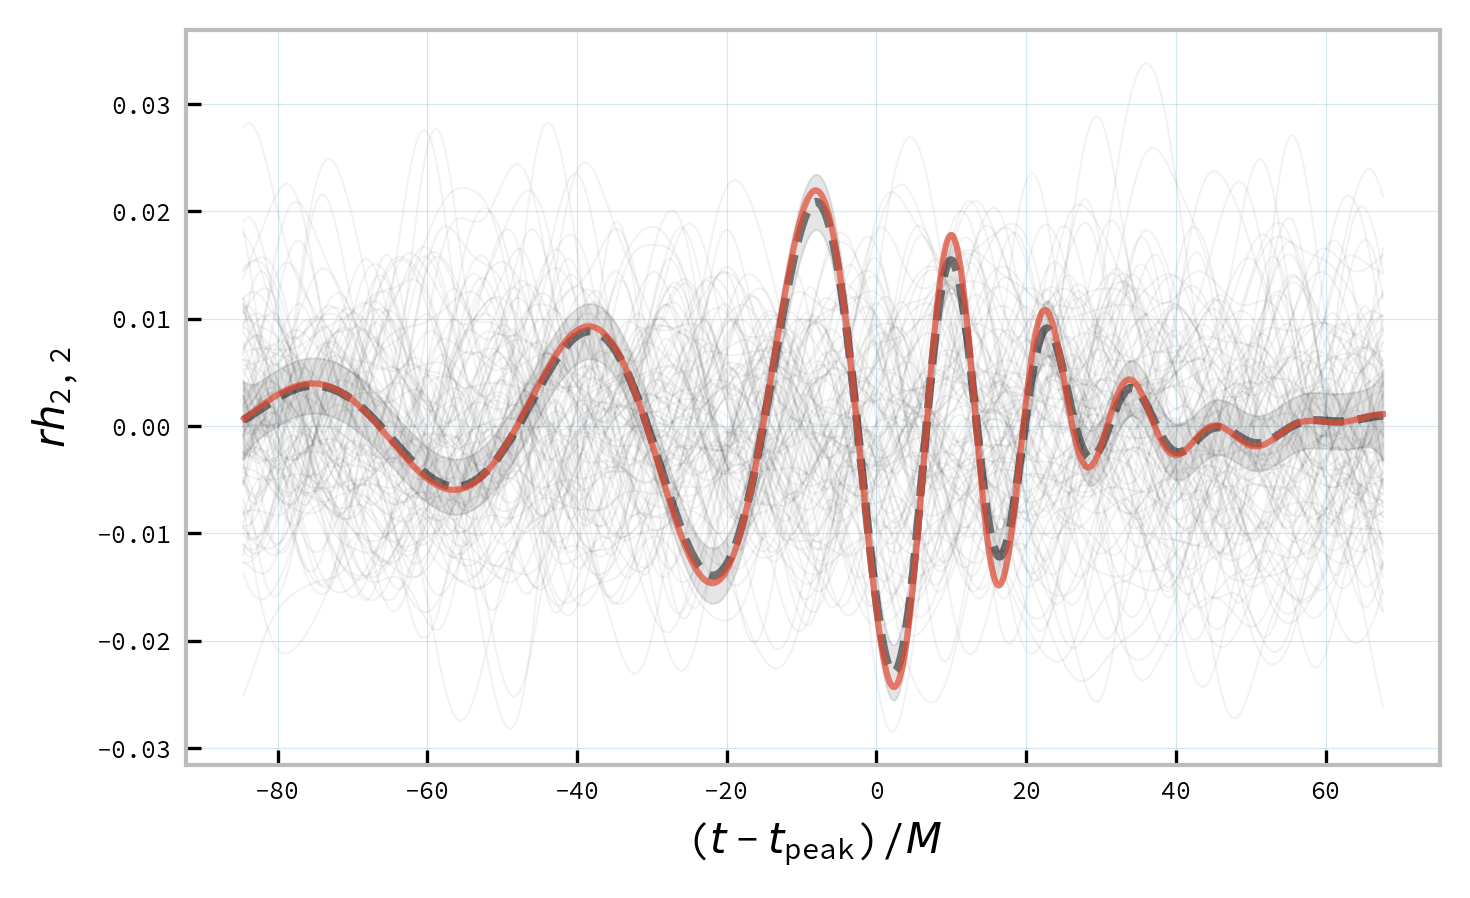

In [13]:
p = {"mass ratio": 0.83,}
f = sample_plot(p, surrogates=imr_cat)
f.savefig("../../figures/heron/imr-test-q0d8.pdf")

/home/daniel/.virtualenvs/IGRlaptop21/heron-stable/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:1579: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


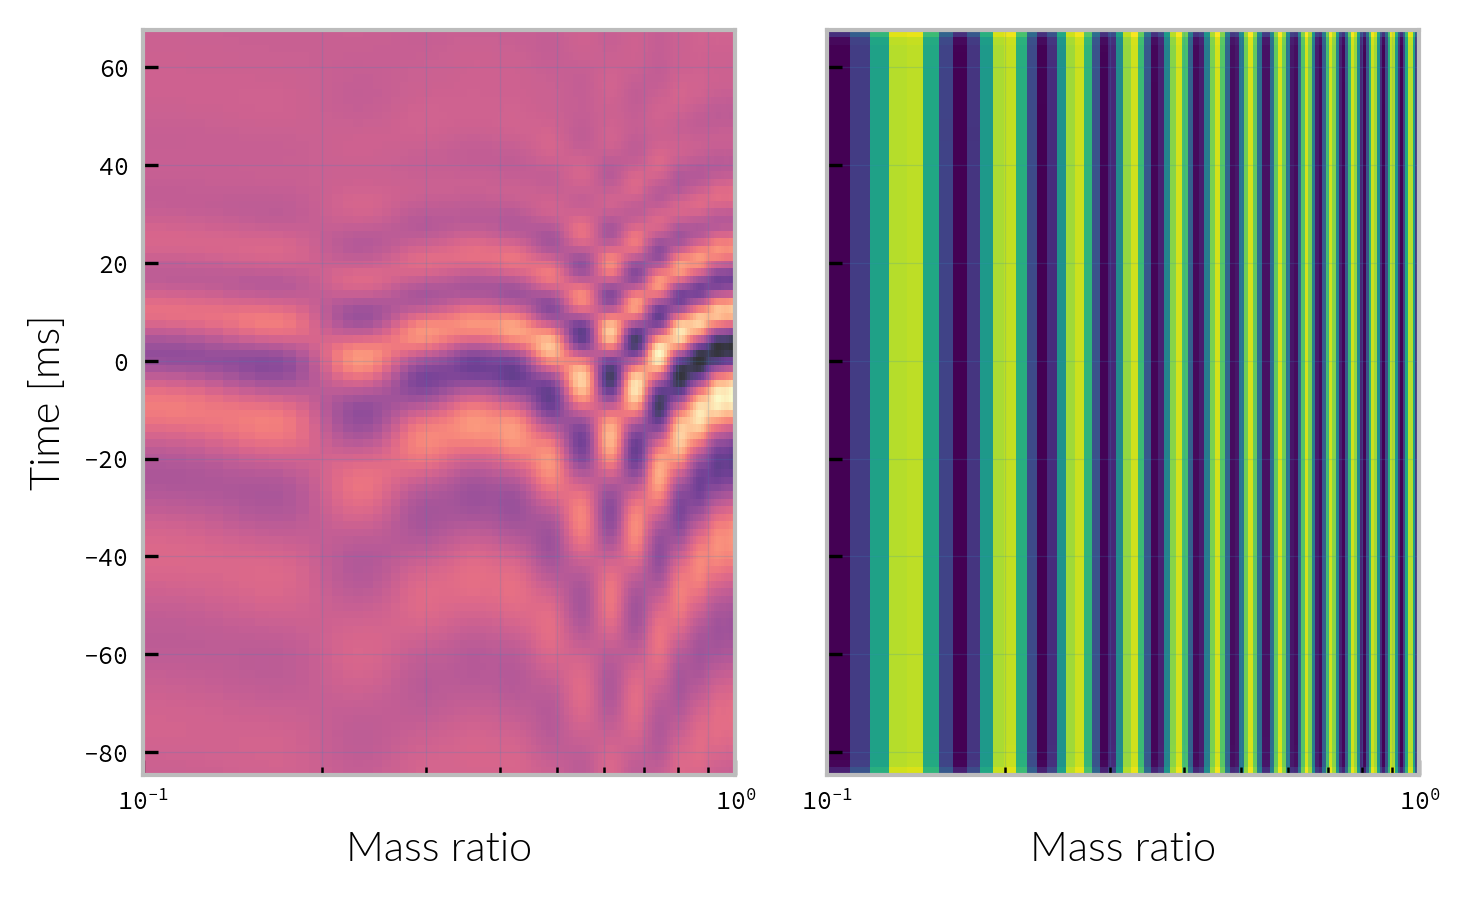

In [14]:
p = {"time": [-250, 200, 100], "mass ratio": [np.log(0.1), np.log(1.0), 100], }
f, mean, var = plot_planes(p, fixed={})
f = thesis.thesisify(f)
f.savefig("../../figures/heron/imr-test-plane.pdf")

In [15]:
import pycbc
import pycbc.psd

In [16]:
def match(a, b, psd=None):
    
    data_a = a.pycbc()
    data_b = b.pycbc()
    
    if psd == "aligo":
        f_low = 5
        f_delta = 1./16
        flen = int(2048/ f_delta) + 1
        psd = pycbc.psd.aLIGOZeroDetHighPower(flen, f_delta, f_low)
    
        return pycbc.filter.match(data_a, data_b, psd=psd)
    
    else:
        return pycbc.filter.match(data_a, data_b)

In [17]:
matches = []
for mass_ratio in np.linspace(0.1, 1.0, 100):
    p = {"mass ratio": mass_ratio }
    a = gp_cat.waveform(p=p, time_range=[-250.,200.,1024])
    p = {"mass ratio": mass_ratio }
    b = imr_cat.waveform(p=p, time_range=[-250.,200.,1024])
    
    matches.append(match(a[0],b[0]))
matches = np.array(matches)

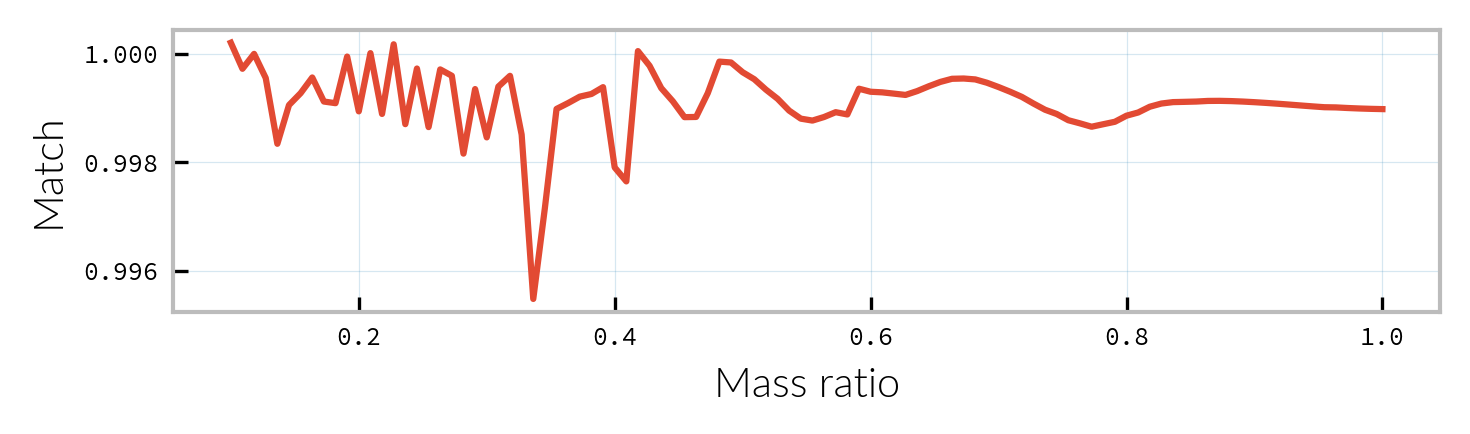

In [18]:
f, ax = plt.subplots(1,1, dpi=300)
ax.plot(np.linspace(0.1, 1.0, 100), matches[:,0])
ax.set_xlabel("Mass ratio")
ax.set_ylabel("Match")
f = thesis.thesisify(f, height=0.5)
f.savefig("../../figures/heron/imr-test-match.pdf")

In [38]:
pycbc.filter.match?

In [31]:
plt.imshow(mean)

NameError: name 'mean' is not defined

Iteration 0
Computing
Iteration 1
Computing


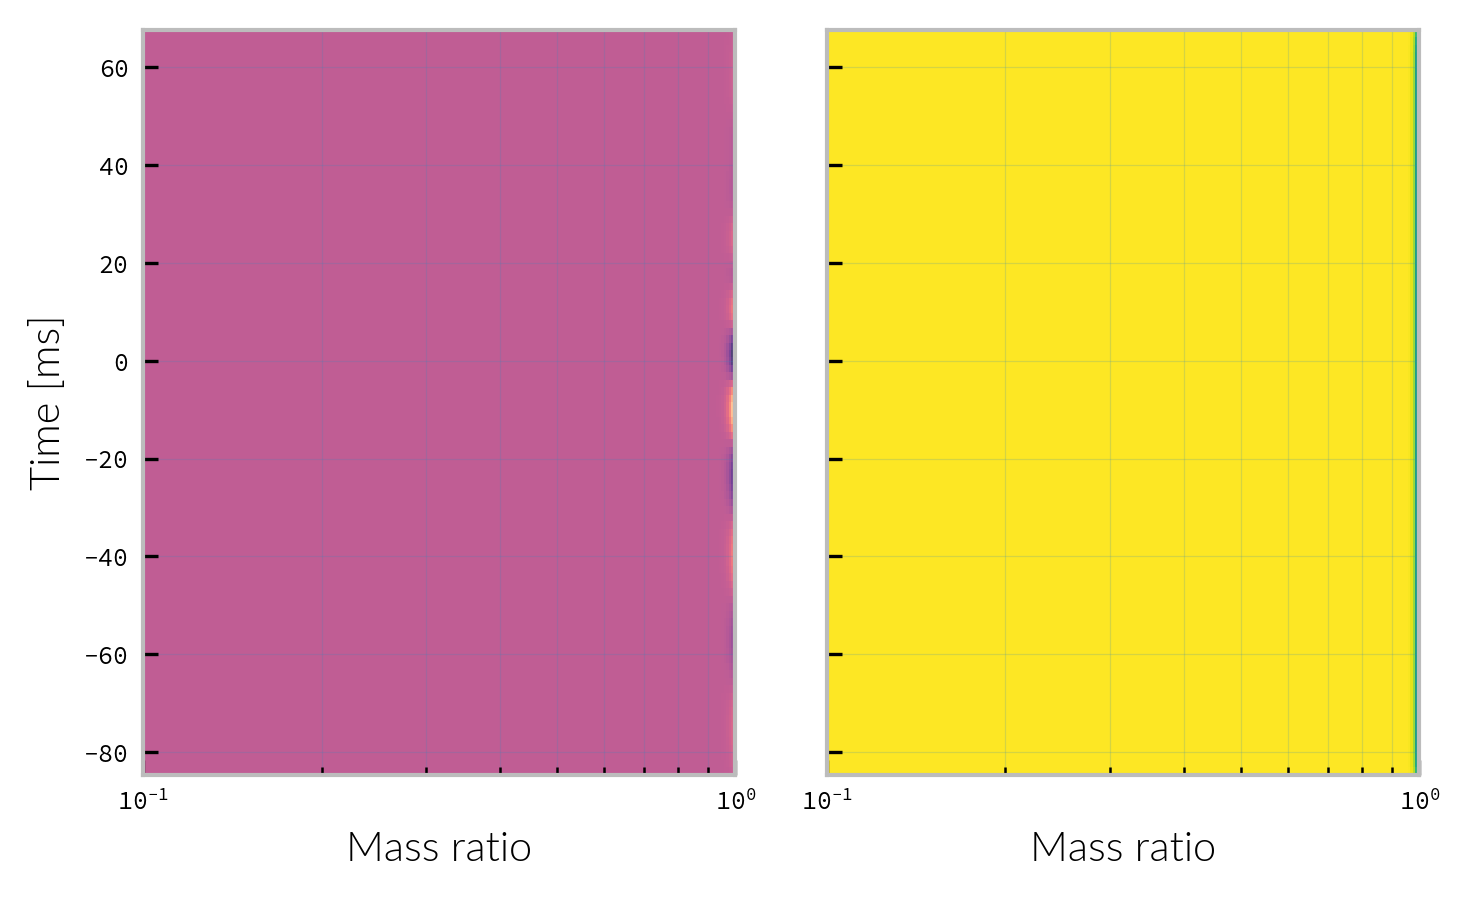

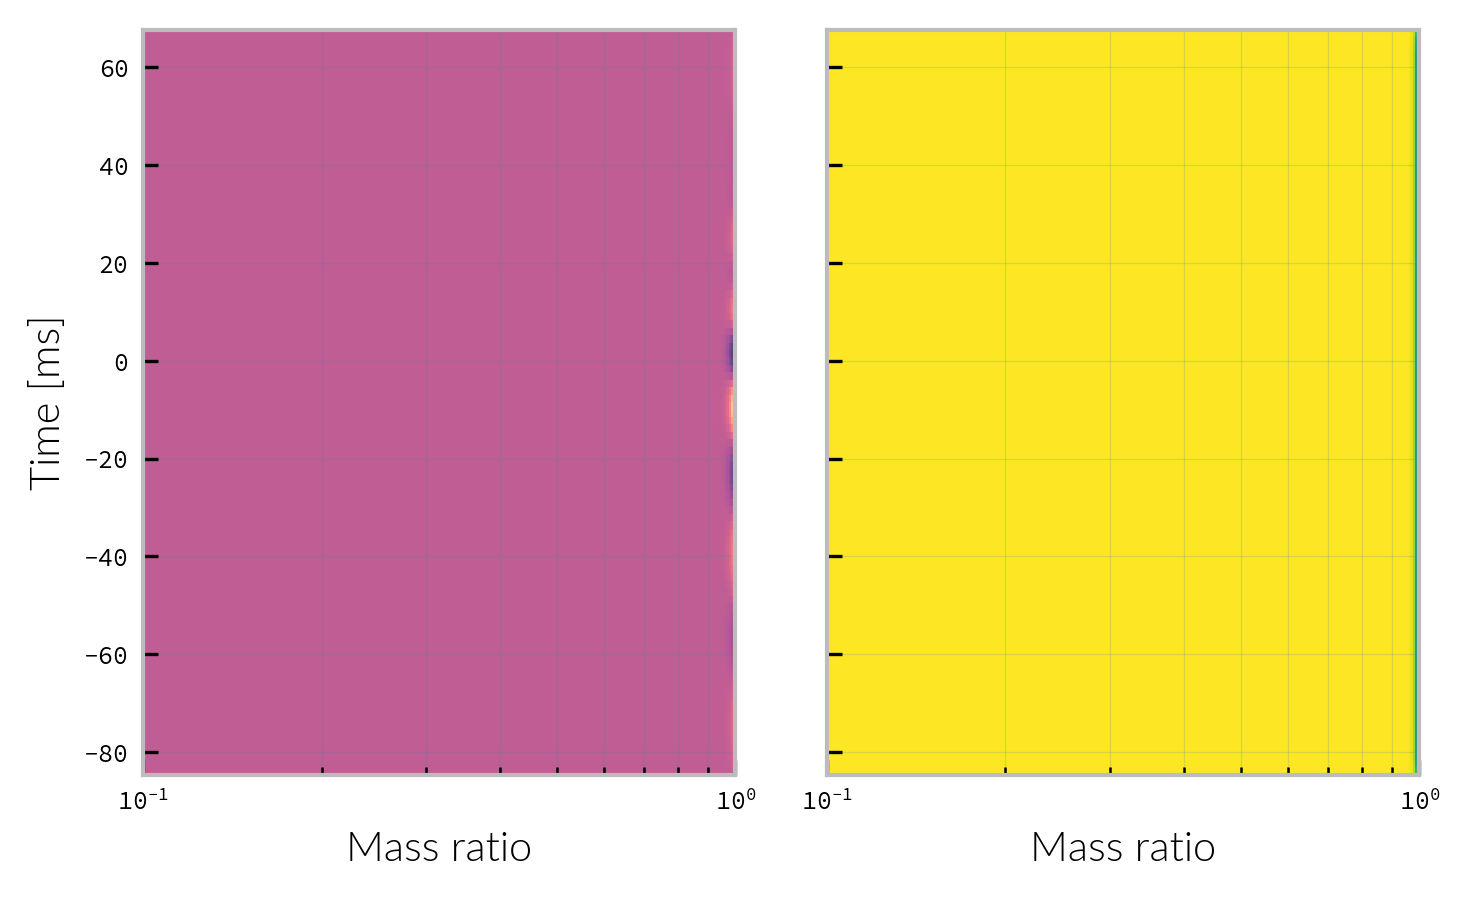

In [14]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.logspace(-1,0,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [np.log(0.1), np.log(1.0), 100], }
    f, mean, var = plot_planes(p, fixed={})

Iteration 0
Computing
Iteration 1
Computing


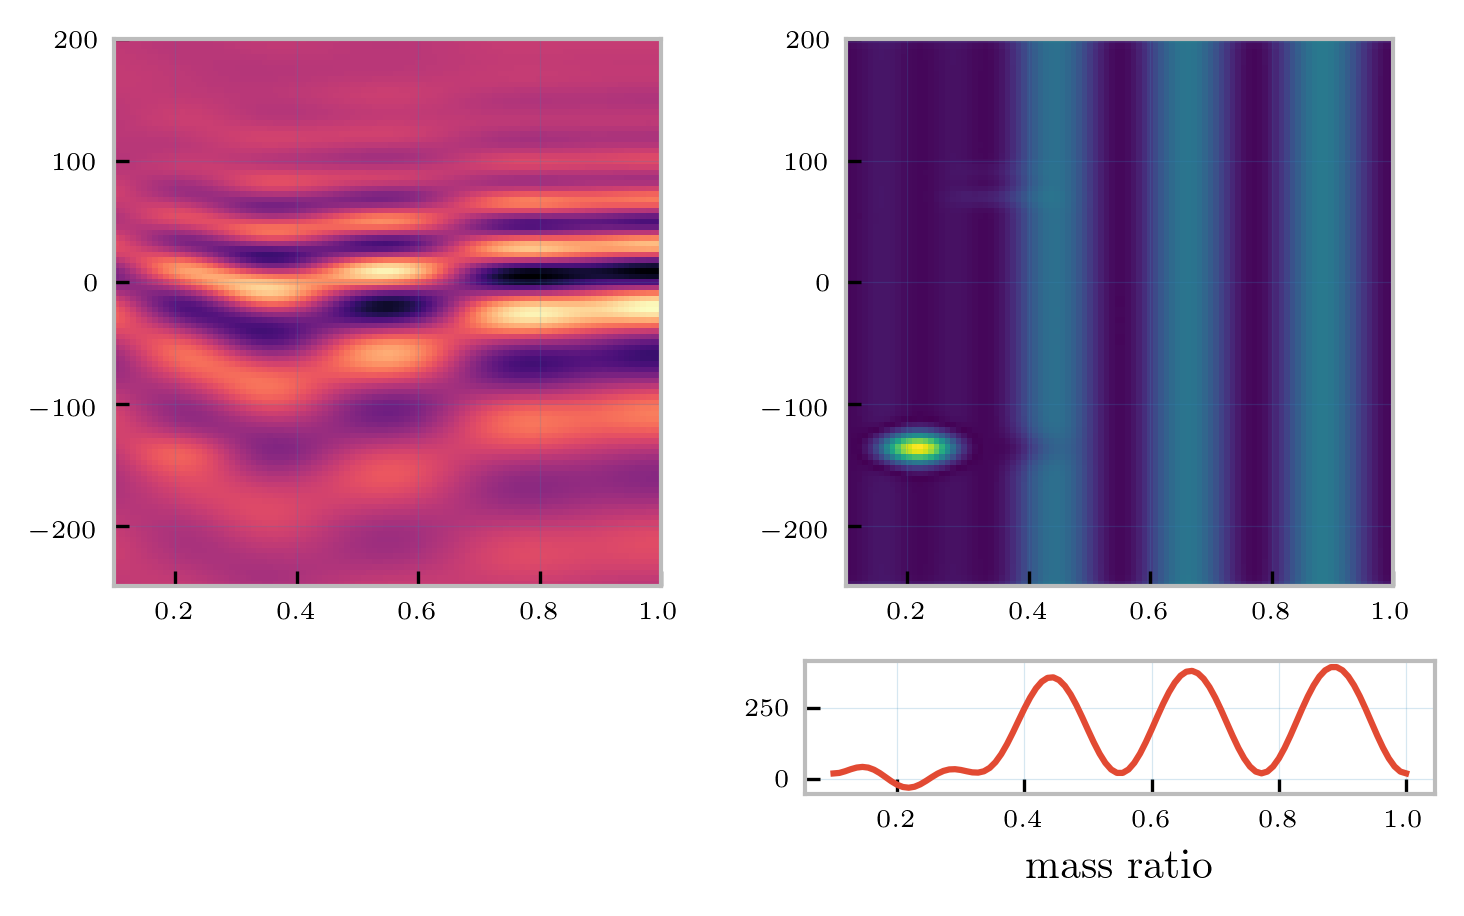

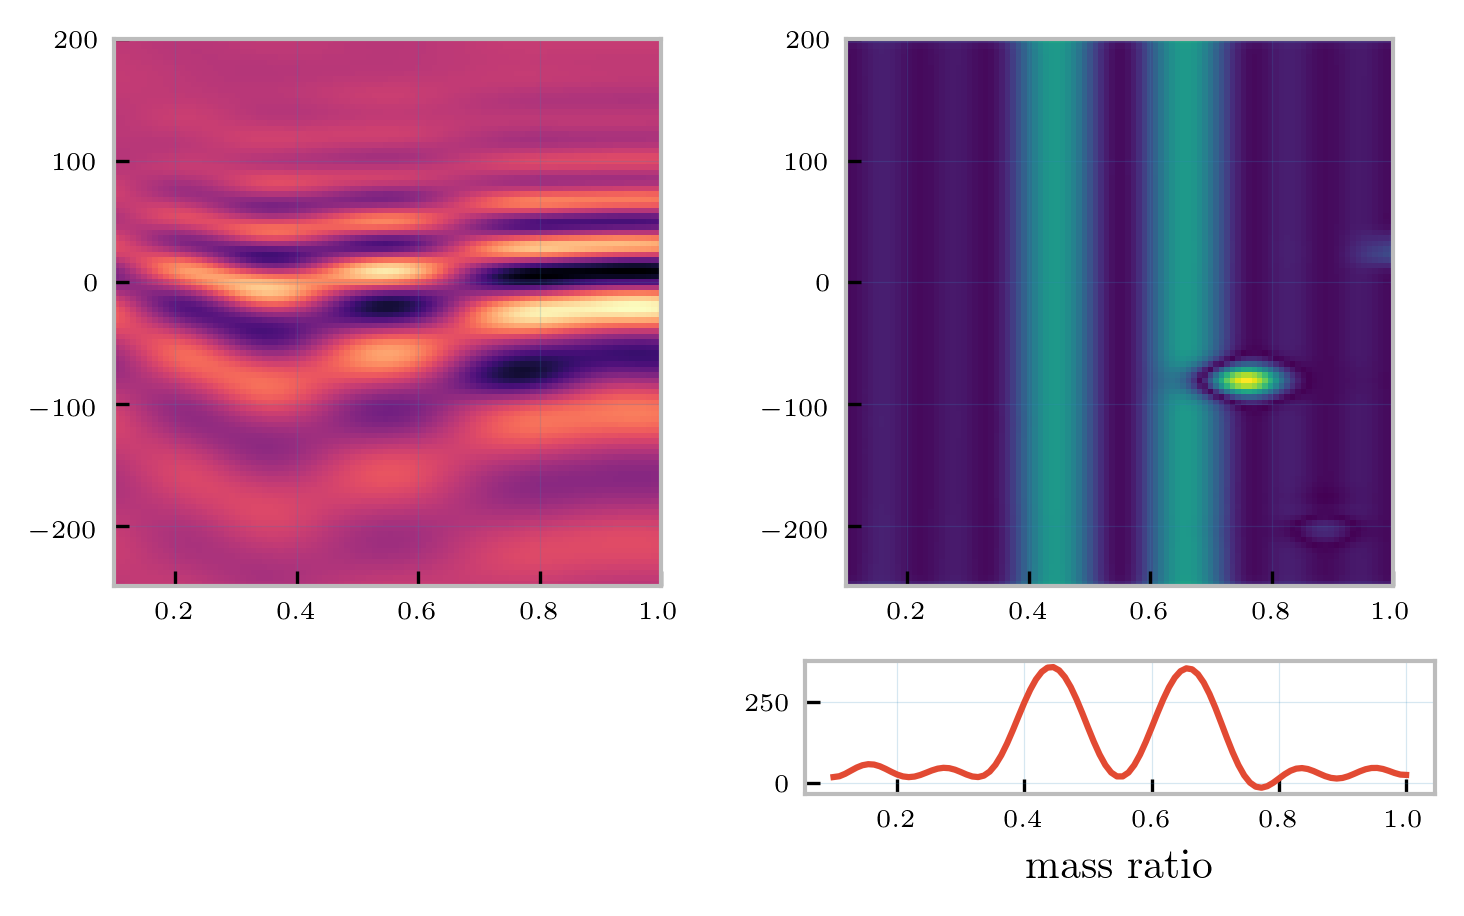

In [14]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.linspace(0.1,1,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [0.1, 1.0, 100], }
    f, mean, var = plot_planes(p, fixed={})

Iteration 0
Computing
Iteration 1
Computing


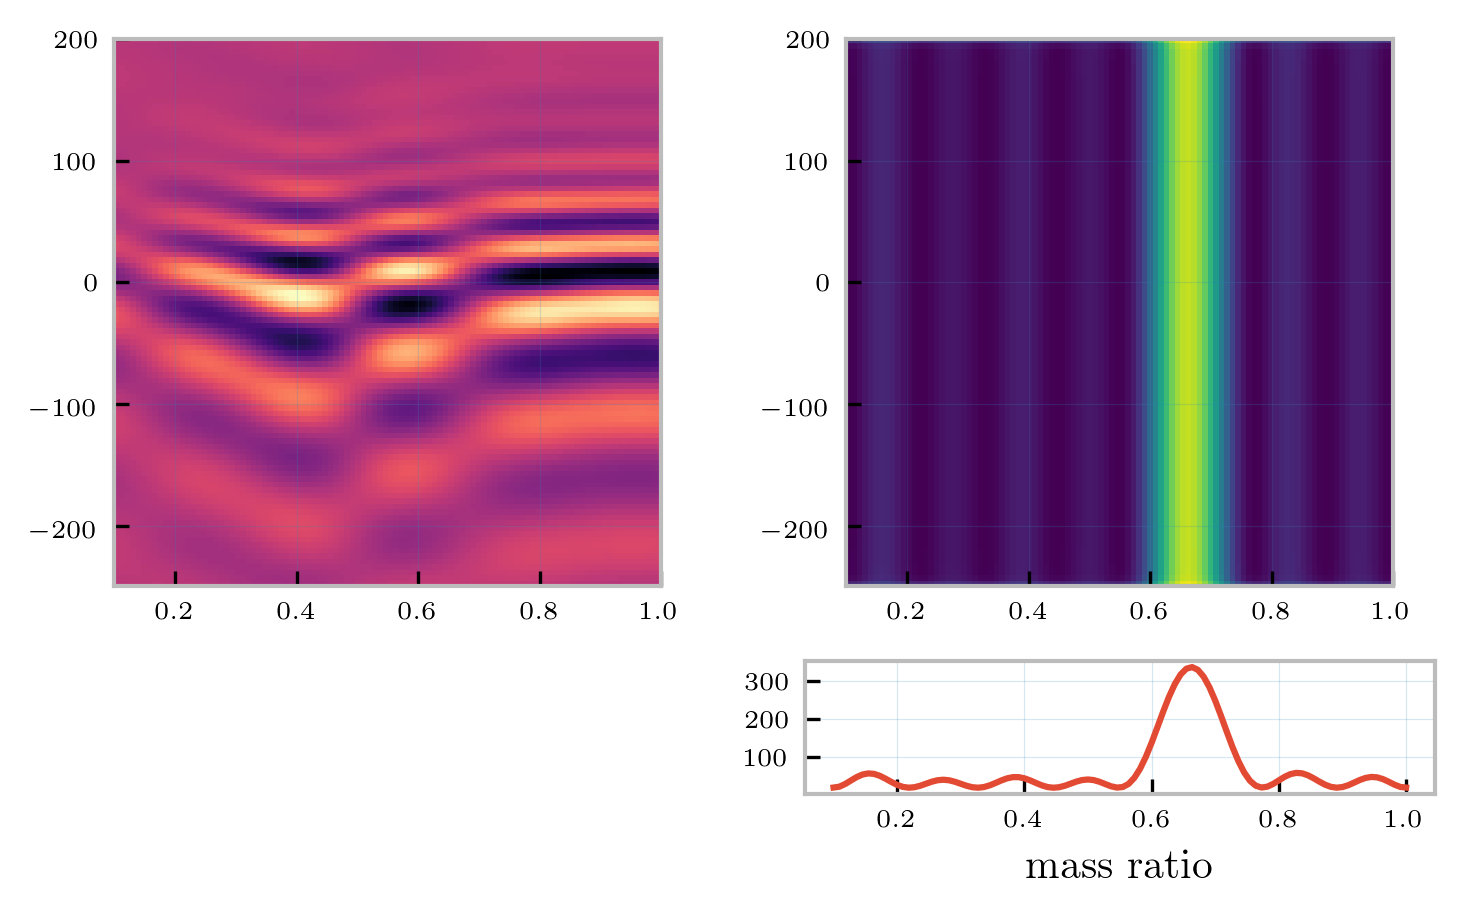

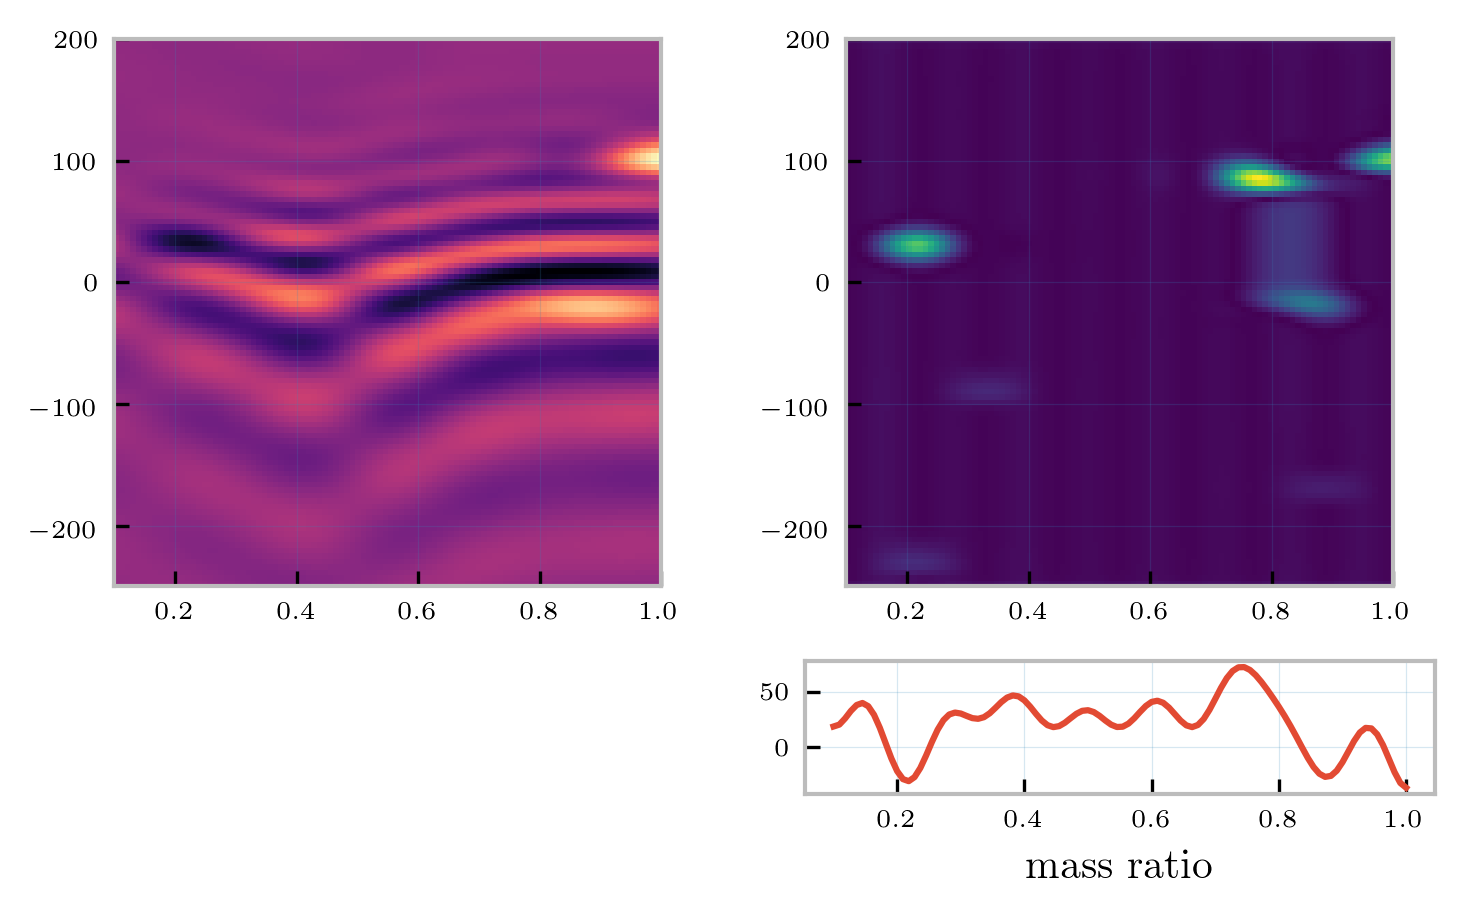

In [15]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.linspace(0.1,1,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [0.1, 1.0, 100], }
    f, mean, var = plot_planes(p, fixed={})

Iteration 0
Computing
Iteration 1
Computing


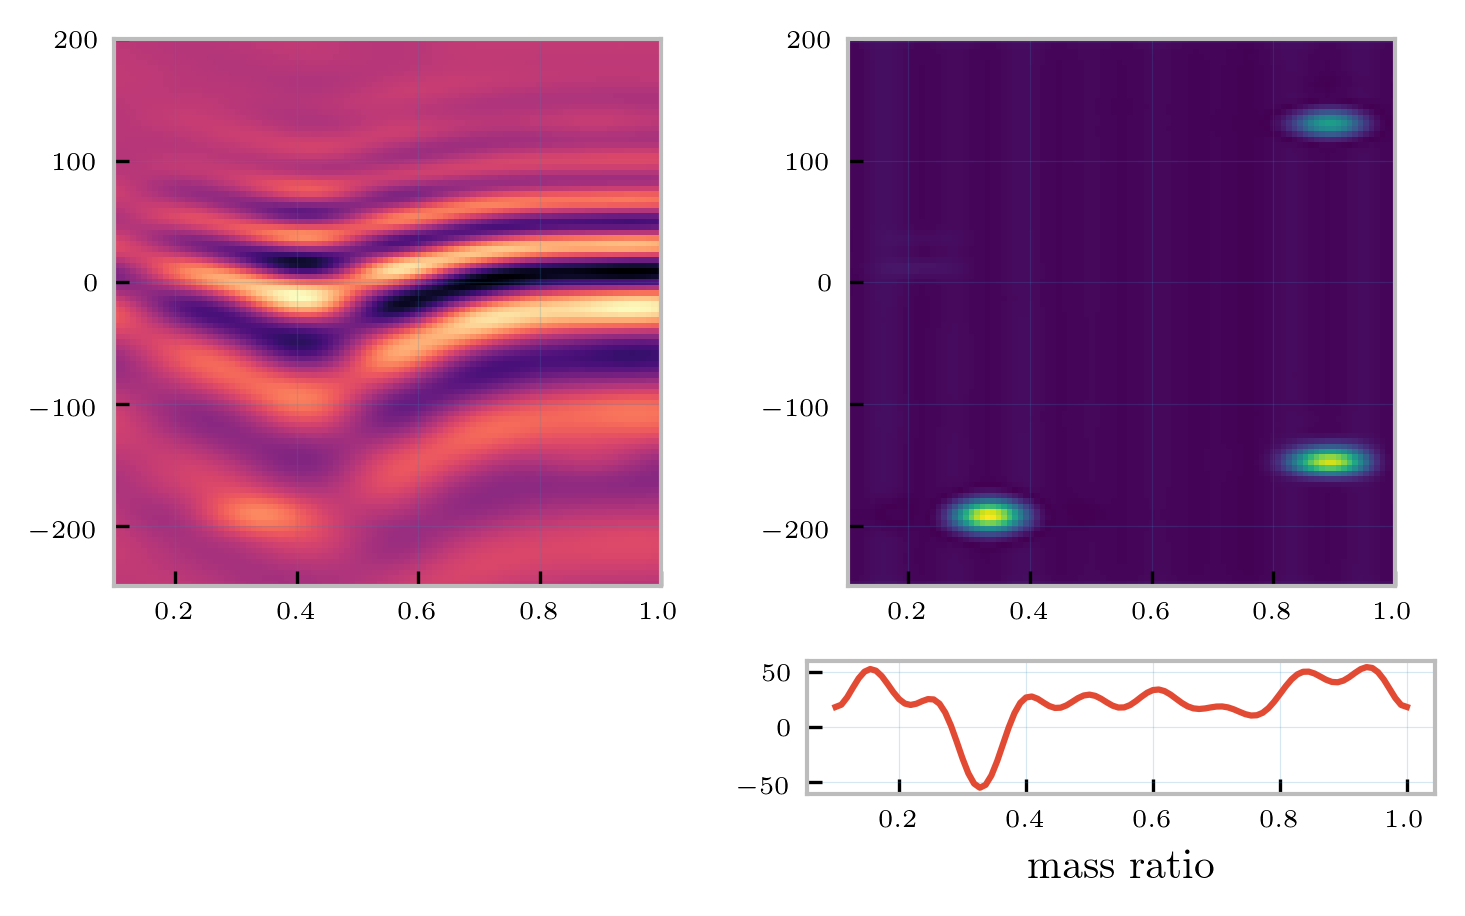

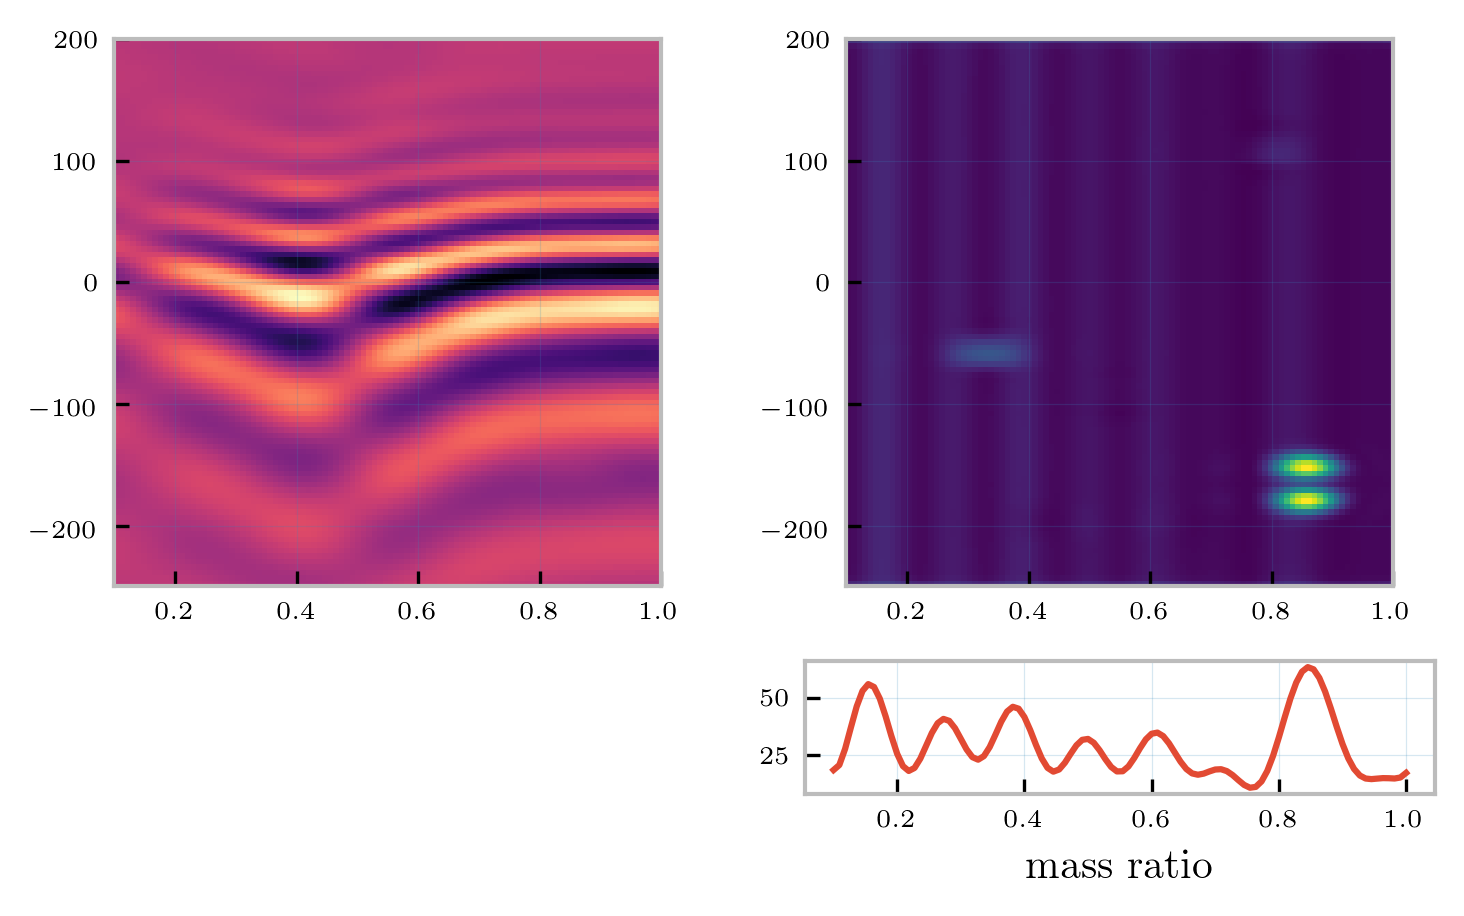

In [16]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.linspace(0.1,1,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [0.1, 1.0, 100], }
    f, mean, var = plot_planes(p, fixed={})